# What a tree based classification/regression model sees

The purpose of this notebook is to generate some examples which can show what a tree based model (Decision Tree, Random Forest, xgboost or Lightgbm) sees when it is trying to solve a Regression/Classification problem. This can provide us better intuition about feature engineering when using tree based algorithms.

The train data used here is sourced from a Kaggle competition "Santander Customer Transaction Prediction". The data can be downloaded from https://www.kaggle.com/c/santander-customer-transaction-prediction/data


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataloc = '/home/sandip/Desktop/Kaggle/santander-customer-transaction-prediction/input/'
train = pd.read_csv(dataloc + "train.csv")

In [3]:
valid = train.sample(frac=0.2, random_state=42)
train = train[ ~train.index.isin(valid.index) ].sample(frac=1)
cols = [col for col in train.columns if col not in ['target','ID_code']]

The basic building block of a tree based model is a single regression/classification tree. So you can start by thinking about what a tree sees. You can also engineer some features and watch if and how a decision tree regressor/classifier uses them.

In [4]:
model = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(train[cols], train['target'])
pred_val = model.predict(valid[cols])

AUC =  0.6046


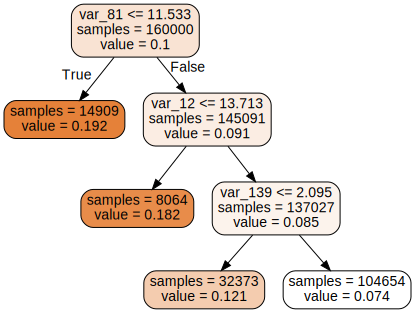

In [5]:
print('AUC = ',round( roc_auc_score(valid['target'],pred_val),4 ) )
tree_graph = tree.export_graphviz(model, out_file=None, max_depth = 10,
    impurity = False, feature_names = cols, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

# Let's review the traget density and traget probability

In [7]:
train0 = train[ train['target']==0 ].copy()
train1 = train[ train['target']==1 ].copy()

setting up some helper functions

In [9]:
# CALCULATE MEANS AND STANDARD DEVIATIONS
s = [0]*200
m = [0]*200
for i in range(200):
    s[i] = np.std(train['var_'+str(i)])
    m[i] = np.mean(train['var_'+str(i)])
    
# CALCULATE PROB(TARGET=1 | X)
def getp(i,x):
    c = 3 #smoothing factor
    a = len( train1[ (train1['var_'+str(i)]>x-s[i]/c)&(train1['var_'+str(i)]<x+s[i]/c) ] ) 
    b = len( train0[ (train0['var_'+str(i)]>x-s[i]/c)&(train0['var_'+str(i)]<x+s[i]/c) ] )
    if a+b<500: return 0.1 #smoothing factor
    # RETURN PROBABILITY
    return a / (a+b)
    # ALTERNATIVELY RETURN ODDS
    # return a / b
    
# SMOOTH A DISCRETE FUNCTION
def smooth(x,st=1):
    for j in range(st):
        x2 = np.ones(len(x)) * 0.1
        for i in range(len(x)-2):
            x2[i+1] = 0.25*x[i]+0.5*x[i+1]+0.25*x[i+2]
        x = x2.copy()
    return x


Showing vars 0 to 7 ...


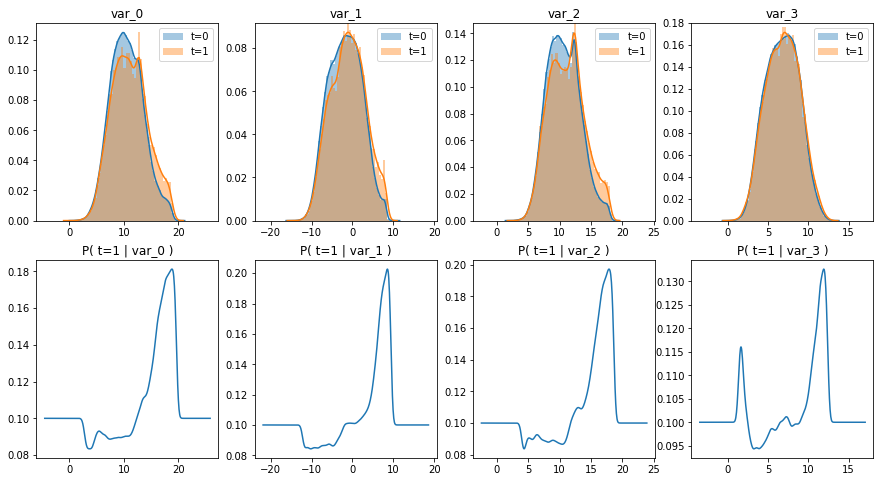

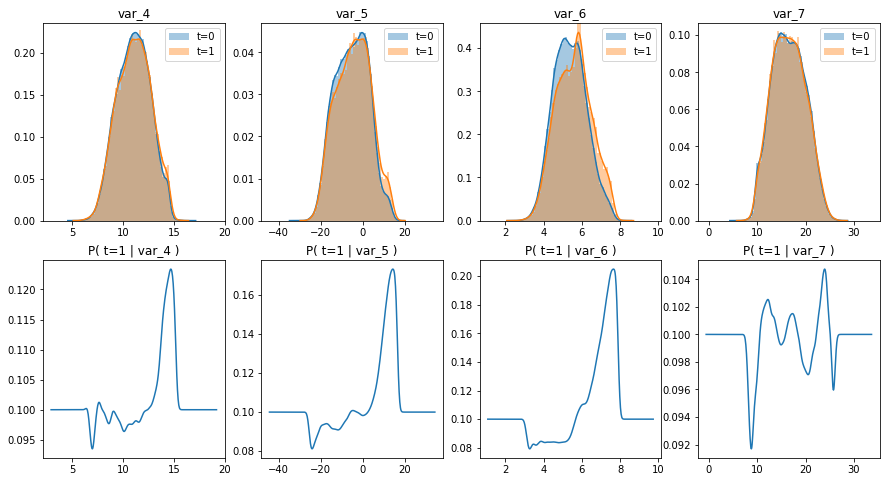

Showing vars 8 to 15 ...


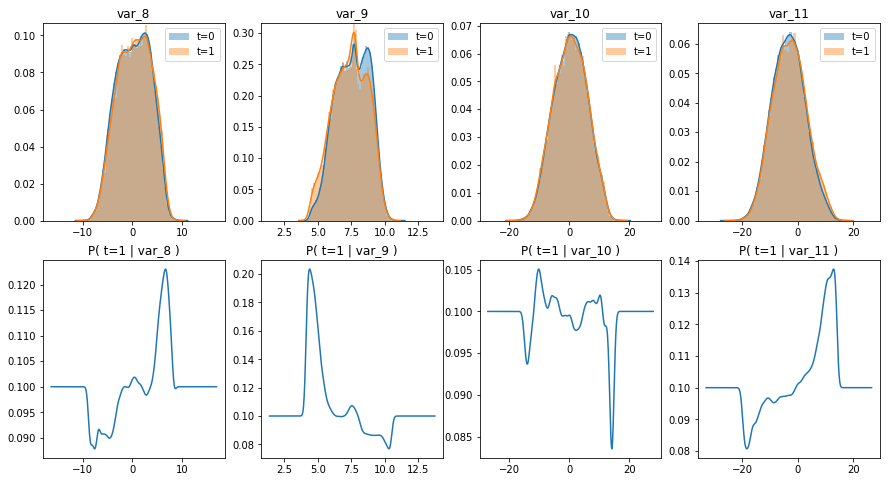

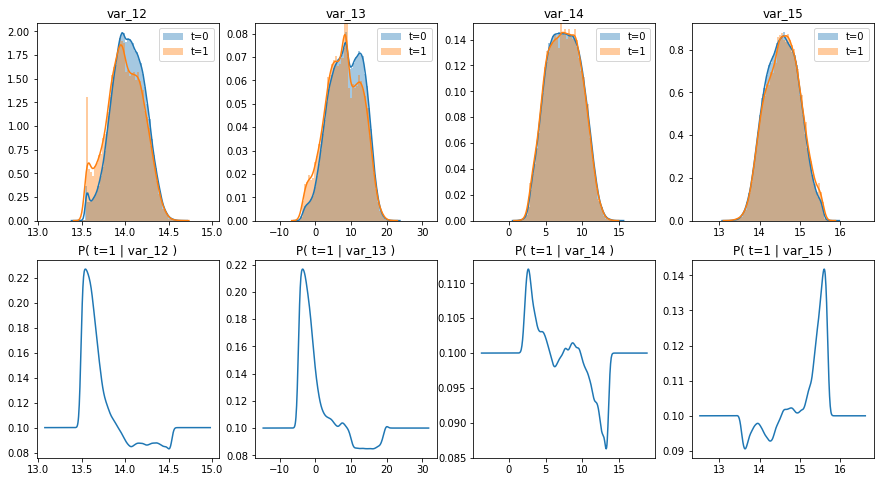

Showing vars 16 to 23 ...


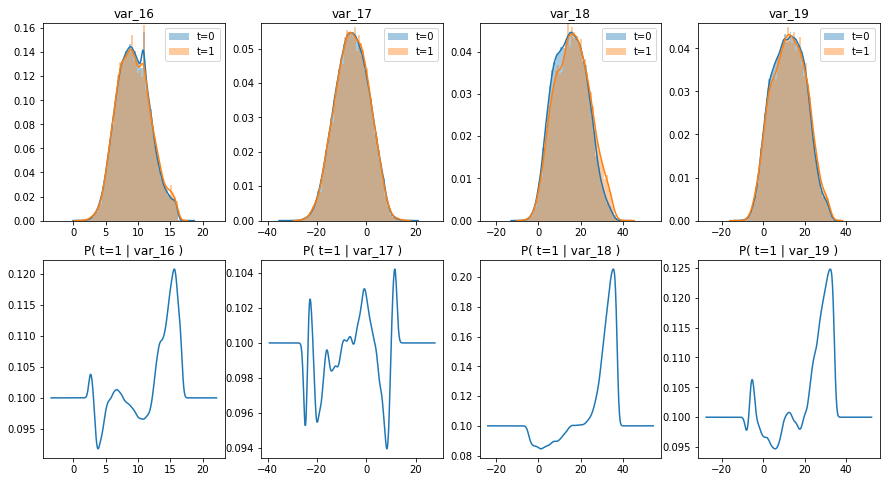

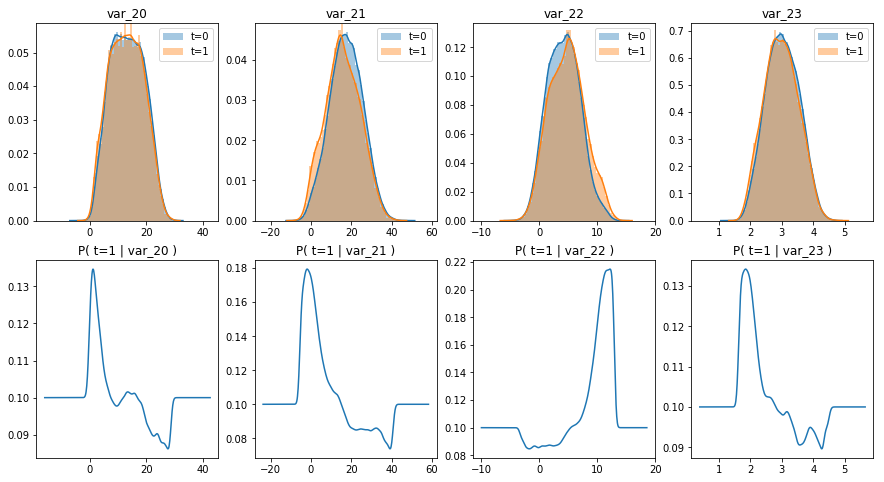

Showing vars 24 to 31 ...


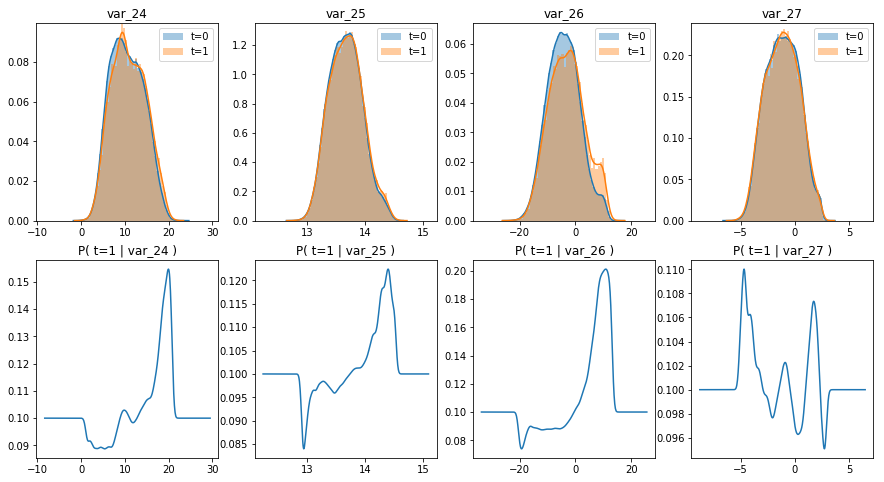

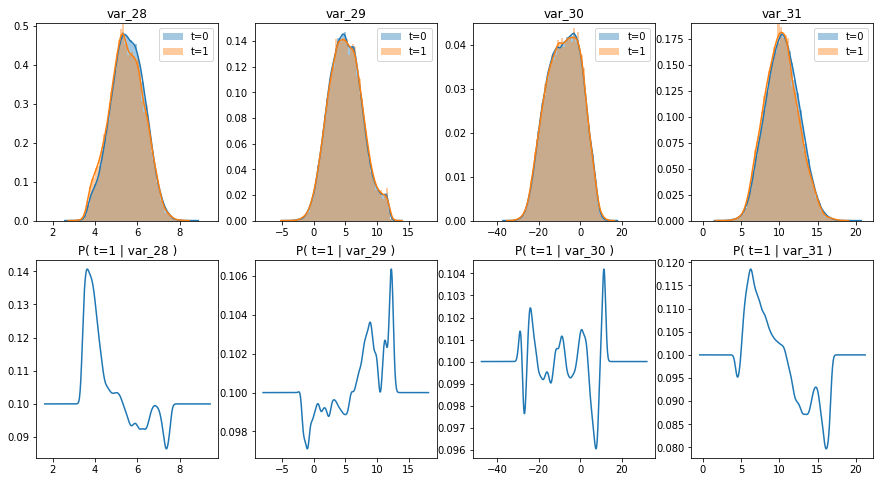

Showing vars 32 to 39 ...


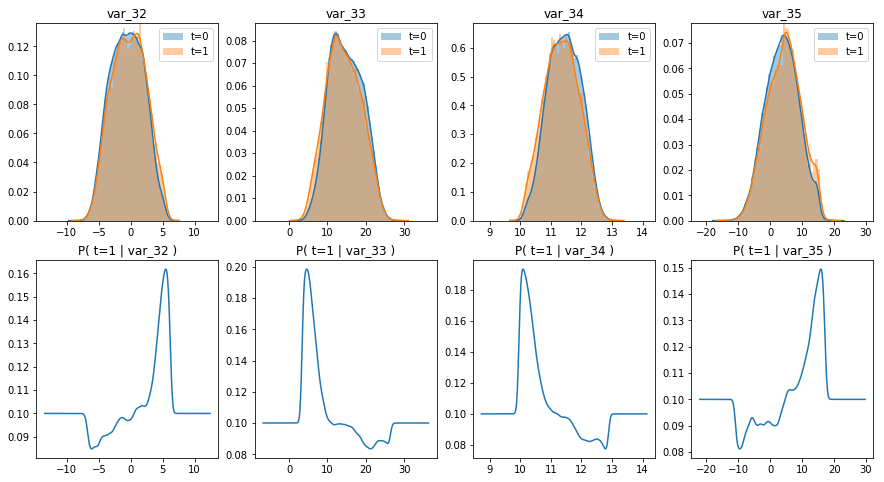

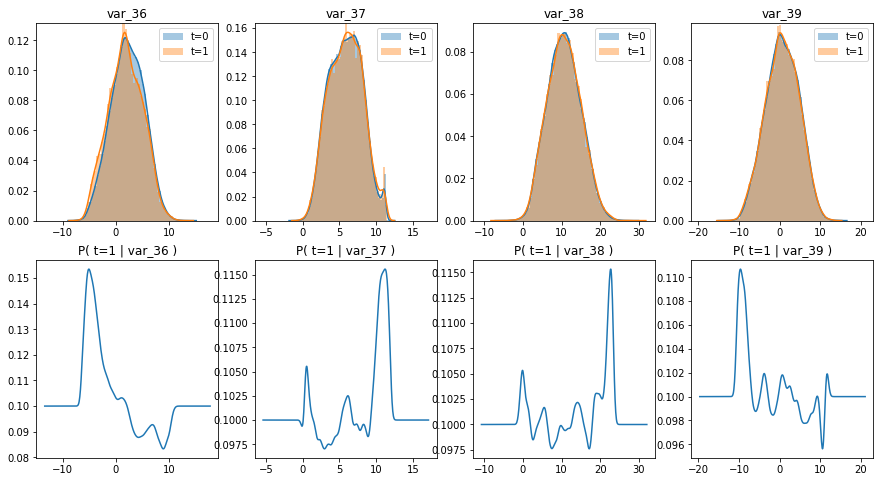

Showing vars 40 to 47 ...


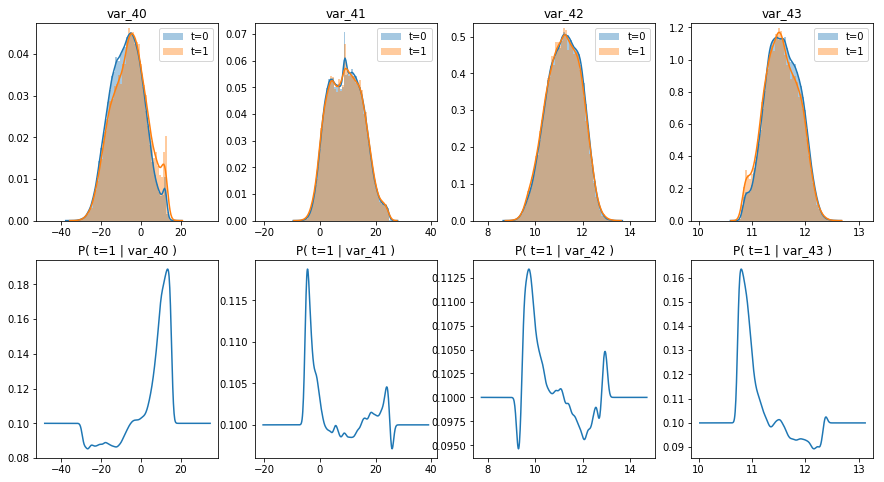

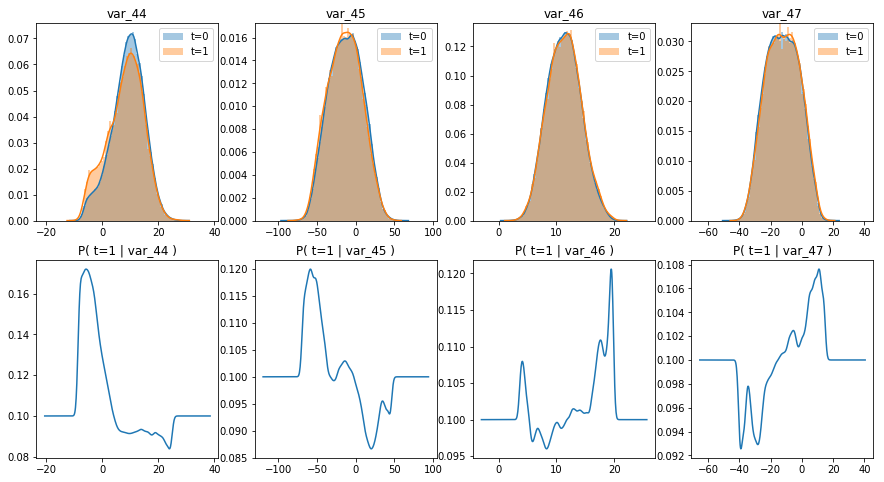

Showing vars 48 to 55 ...


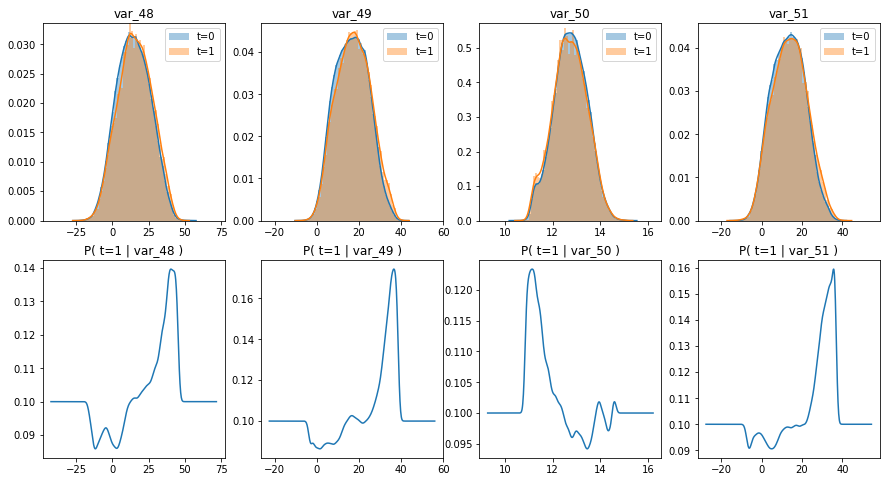

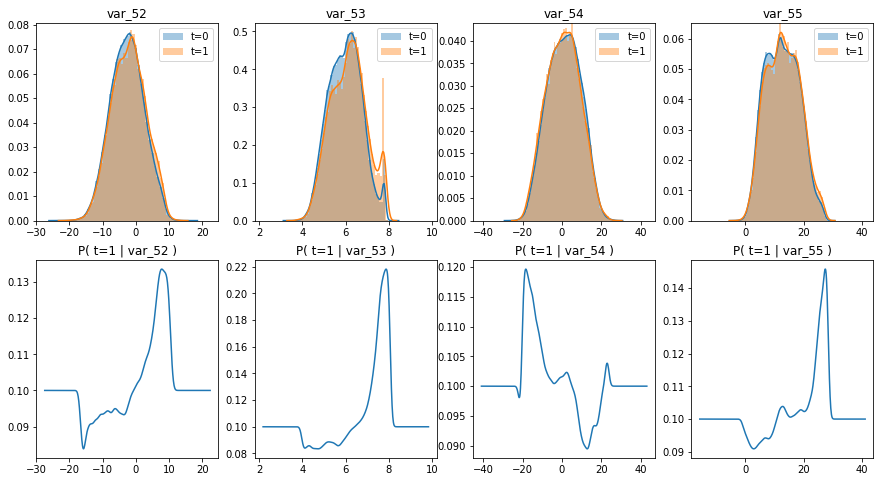

Showing vars 56 to 63 ...


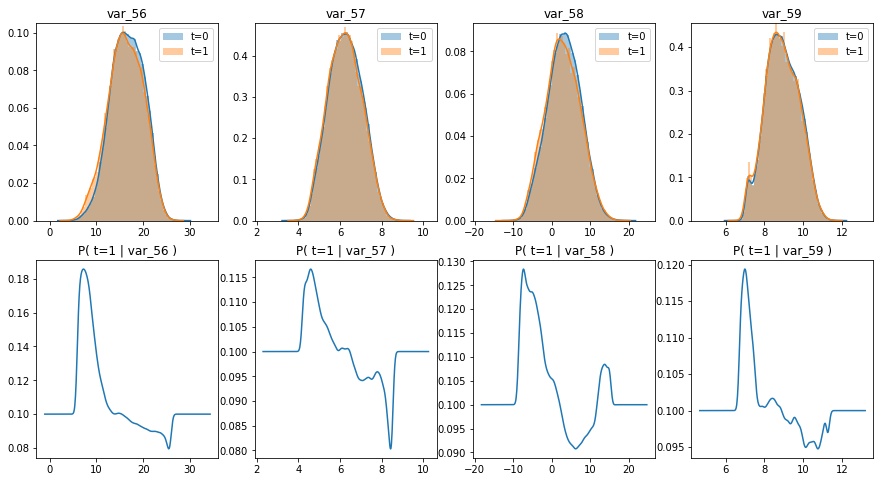

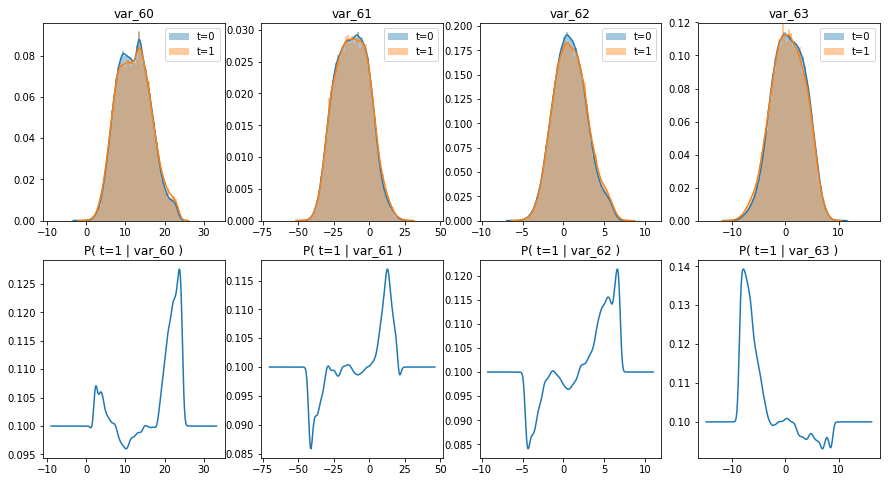

Showing vars 64 to 71 ...


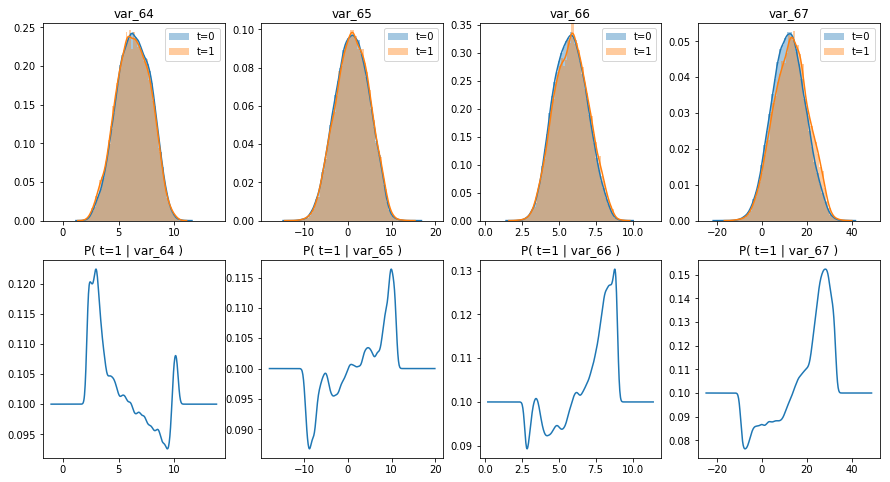

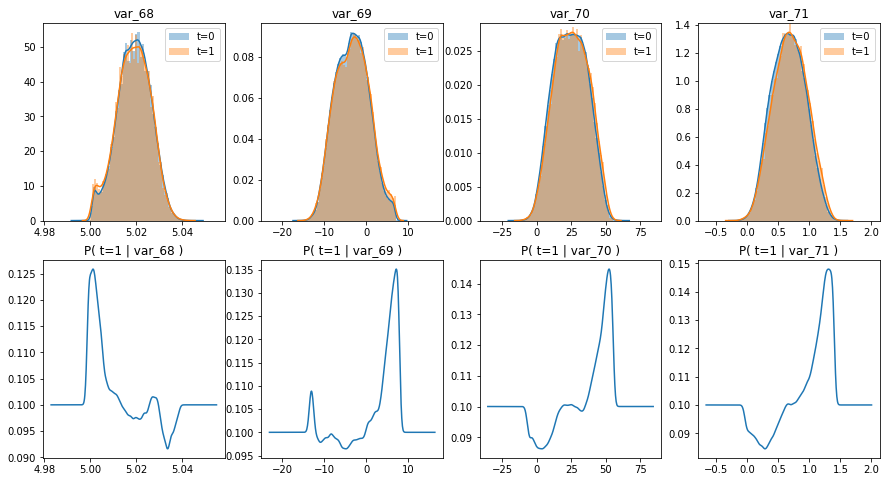

Showing vars 72 to 79 ...


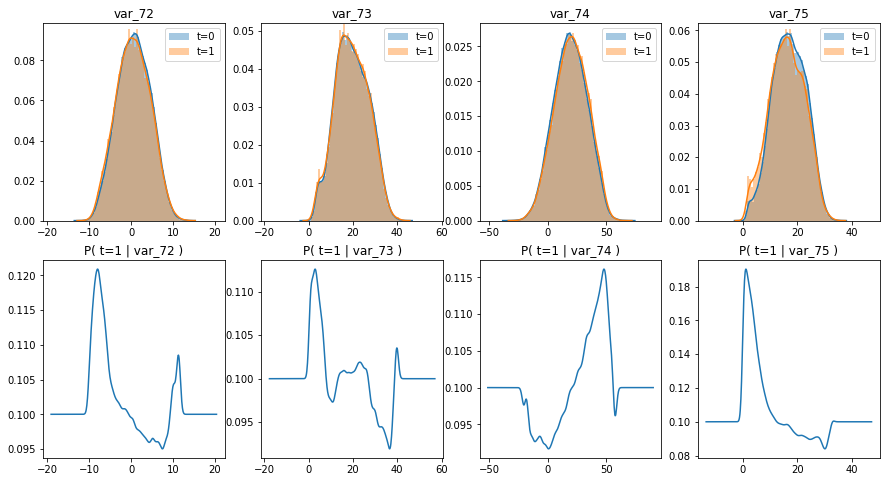

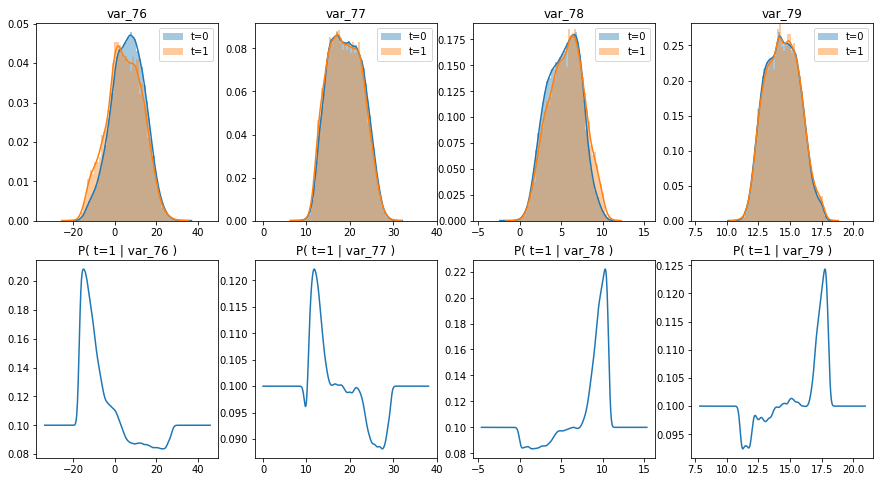

Showing vars 80 to 87 ...


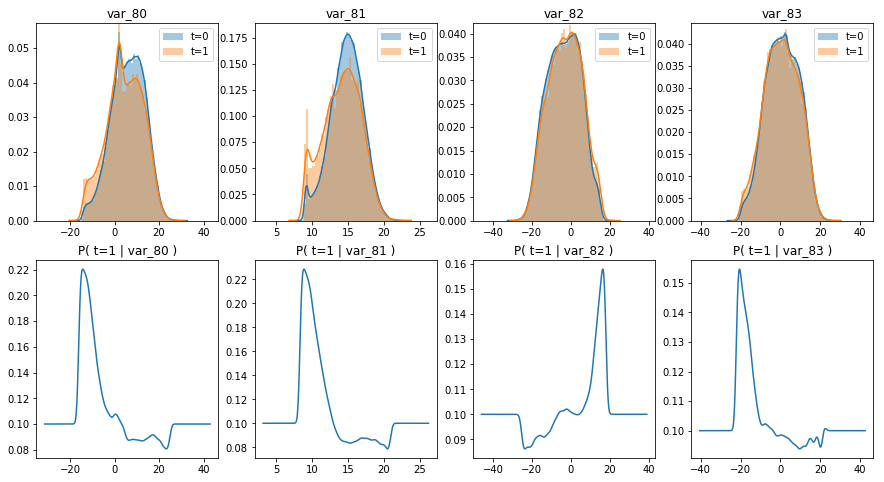

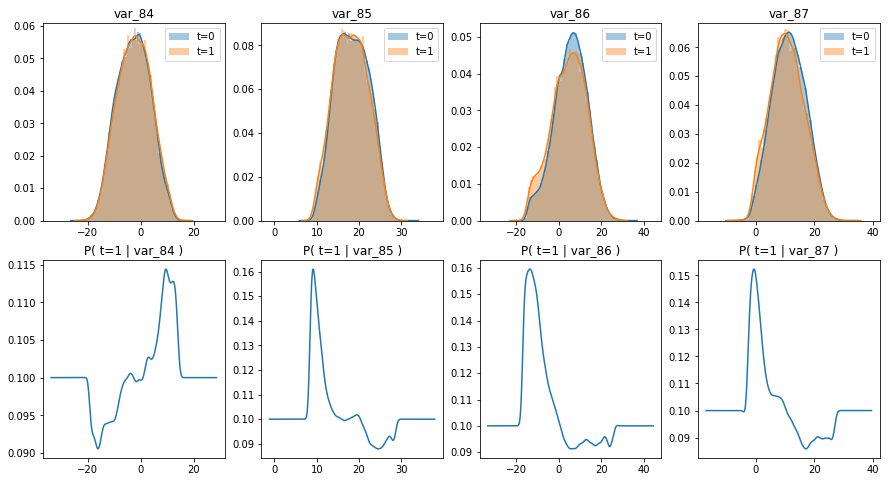

Showing vars 88 to 95 ...


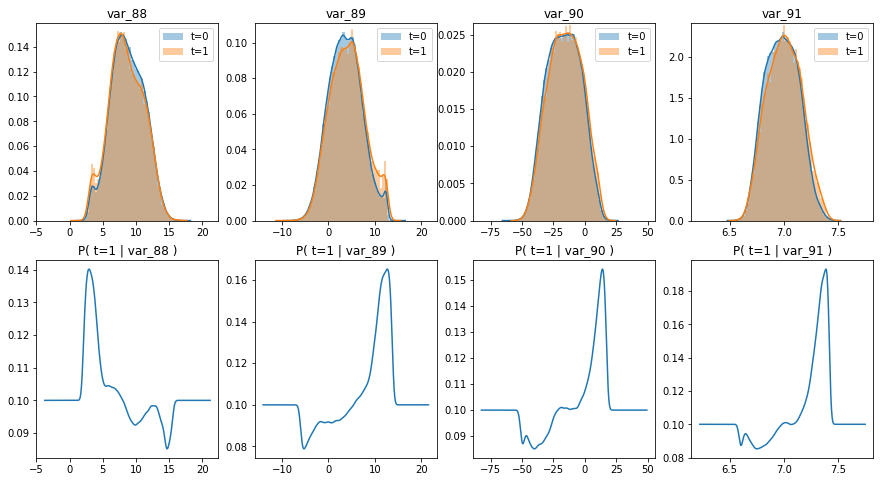

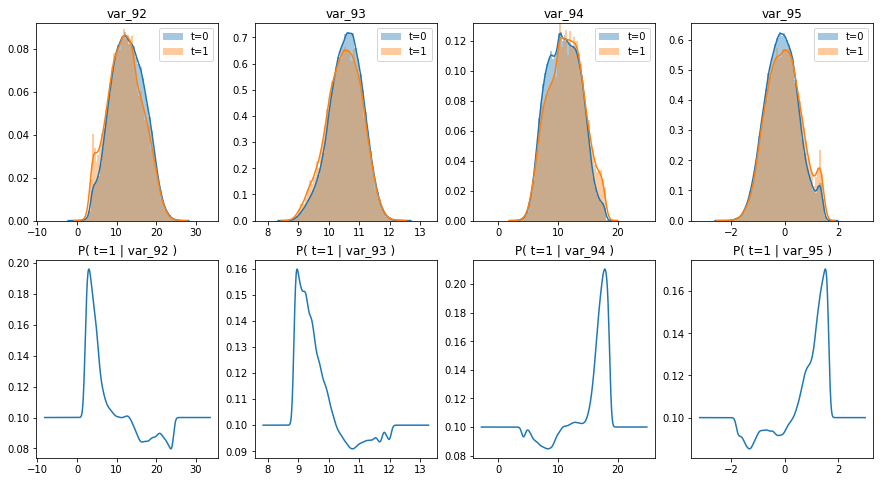

Showing vars 96 to 103 ...


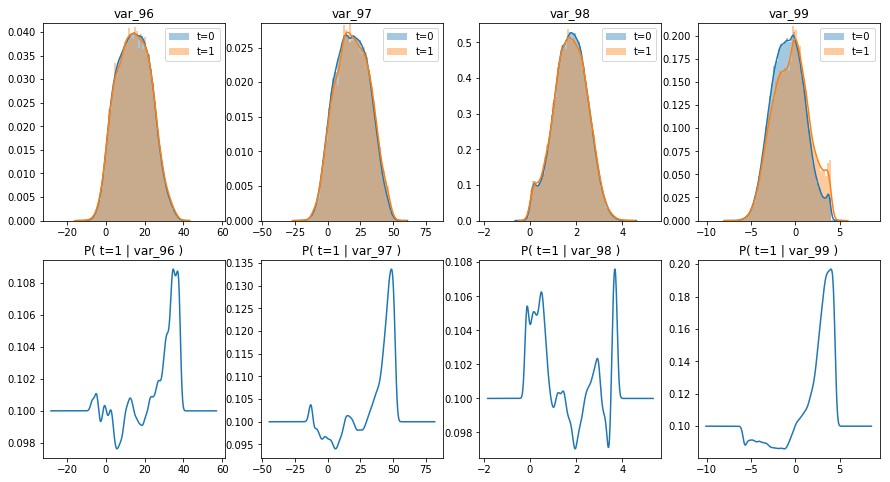

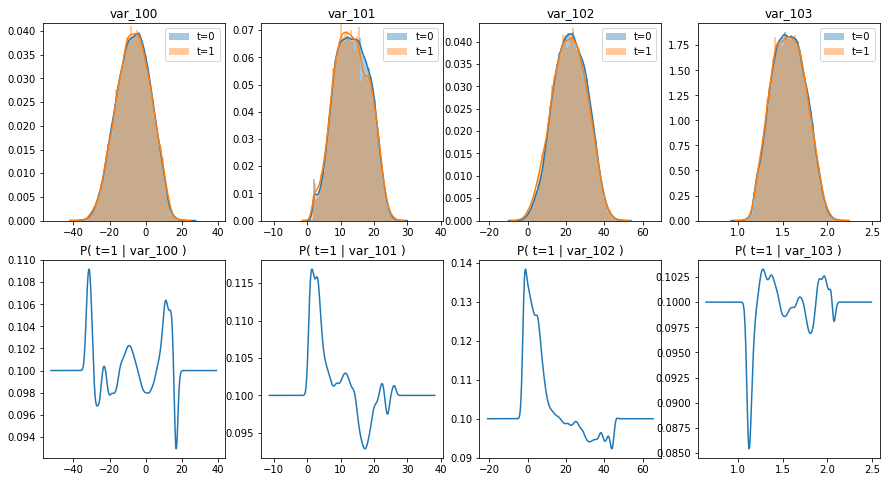

Showing vars 104 to 111 ...


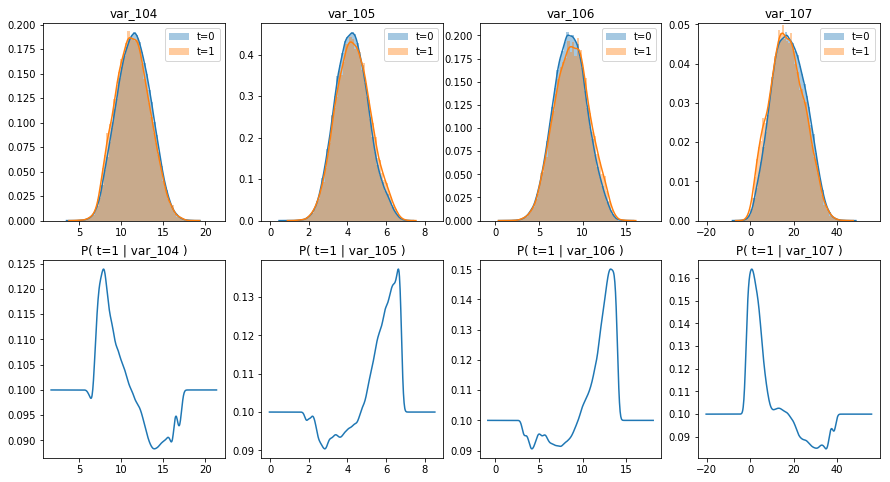

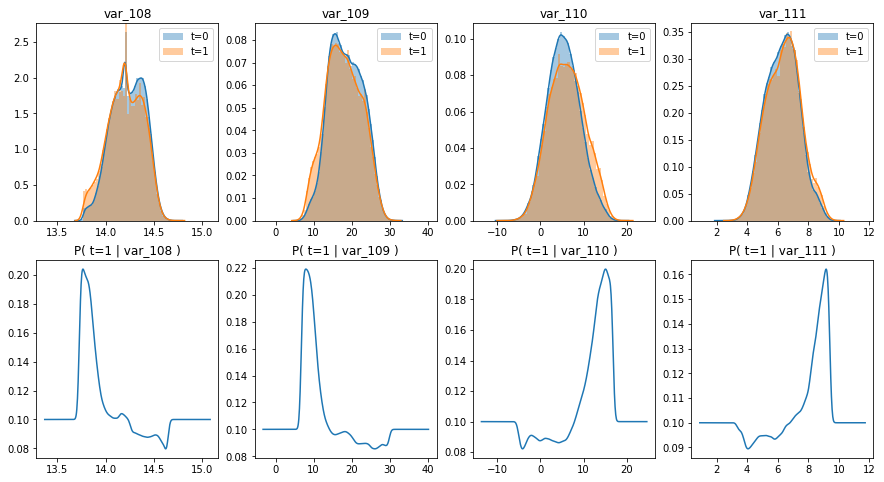

Showing vars 112 to 119 ...


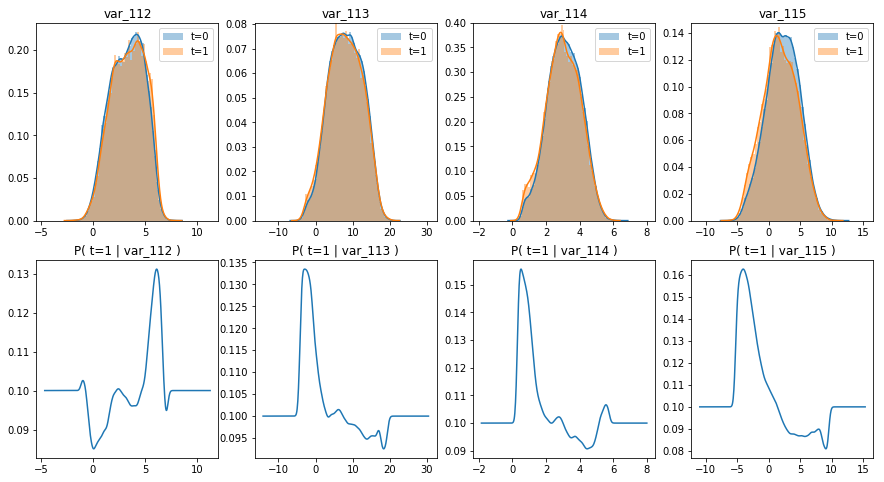

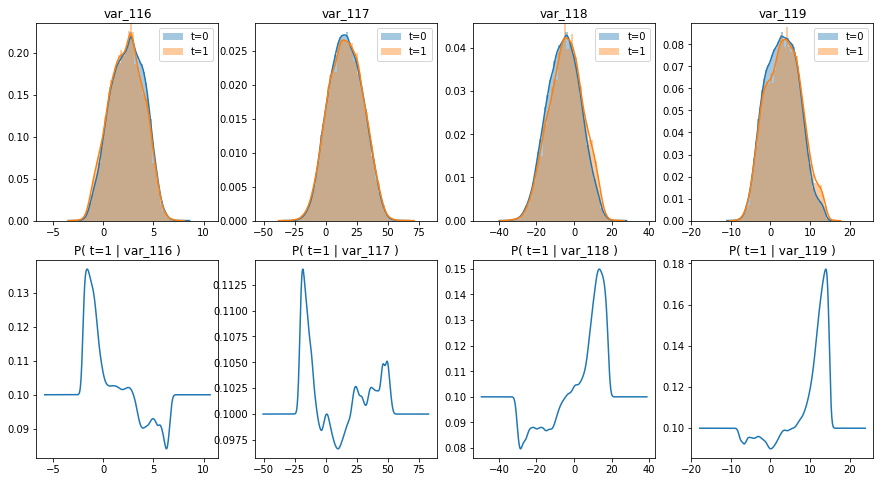

Showing vars 120 to 127 ...


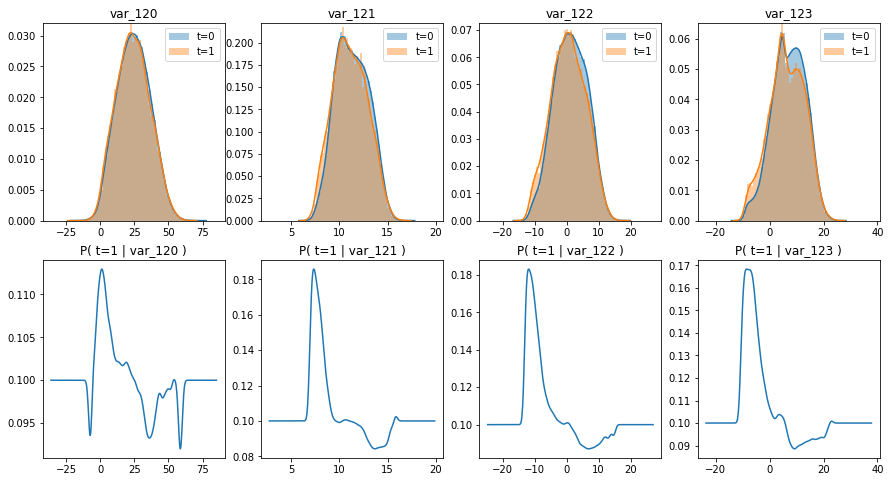

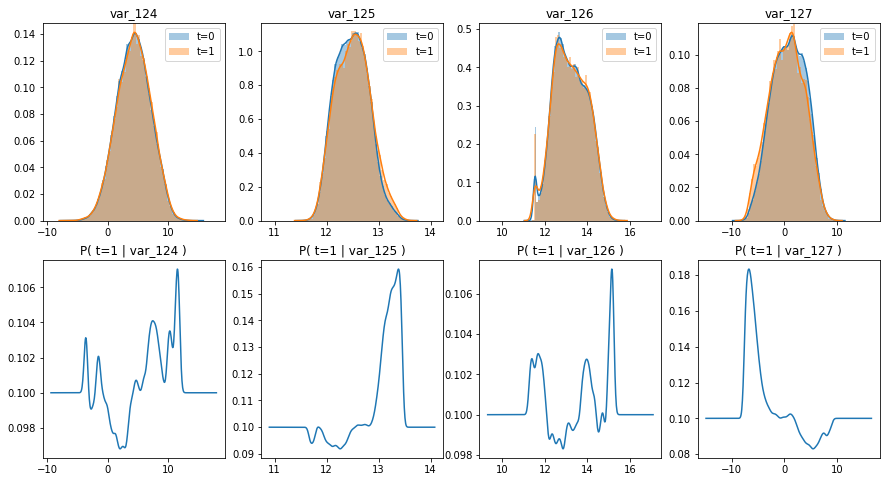

Showing vars 128 to 135 ...


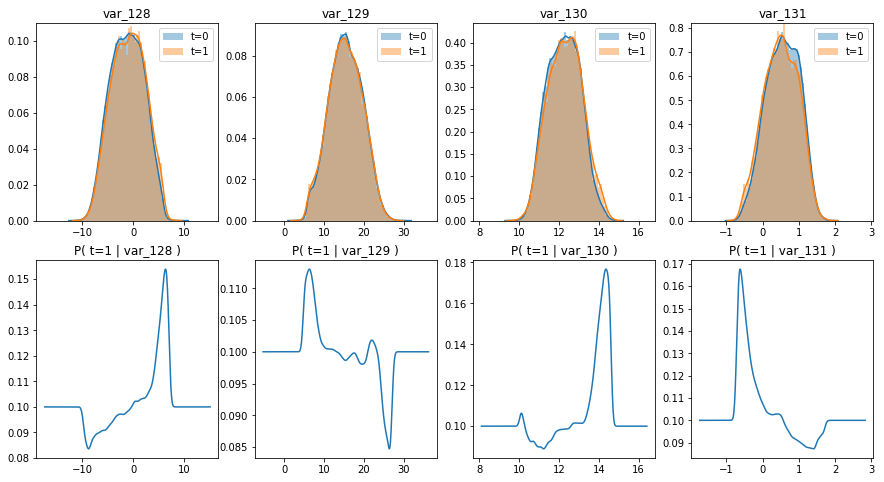

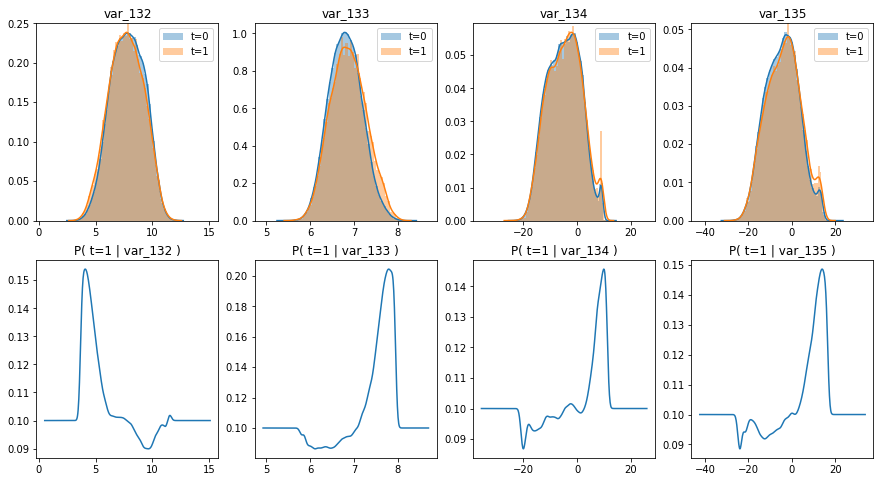

Showing vars 136 to 143 ...


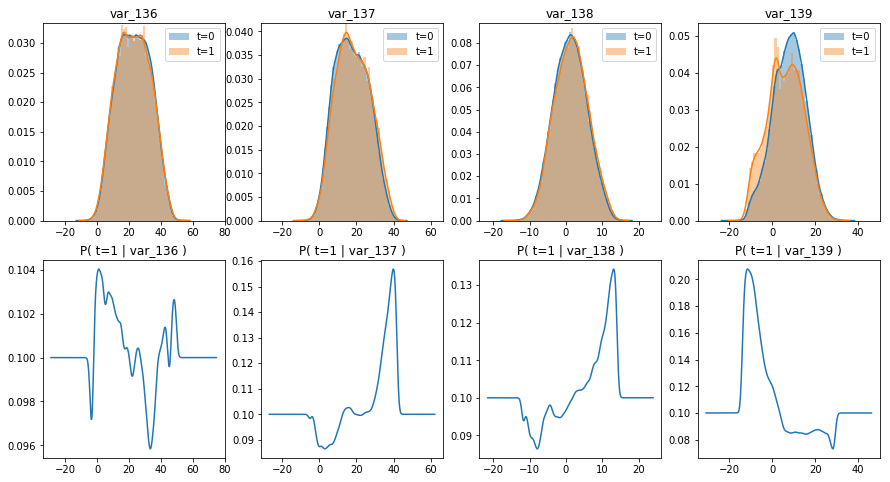

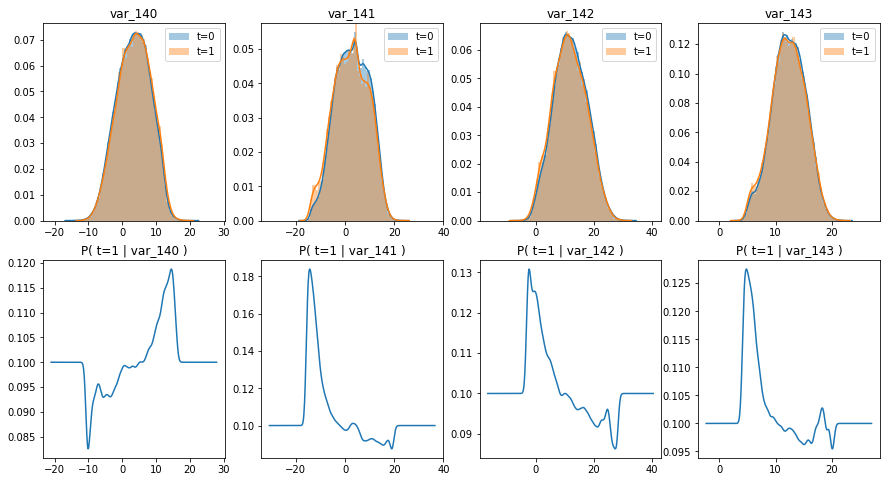

Showing vars 144 to 151 ...


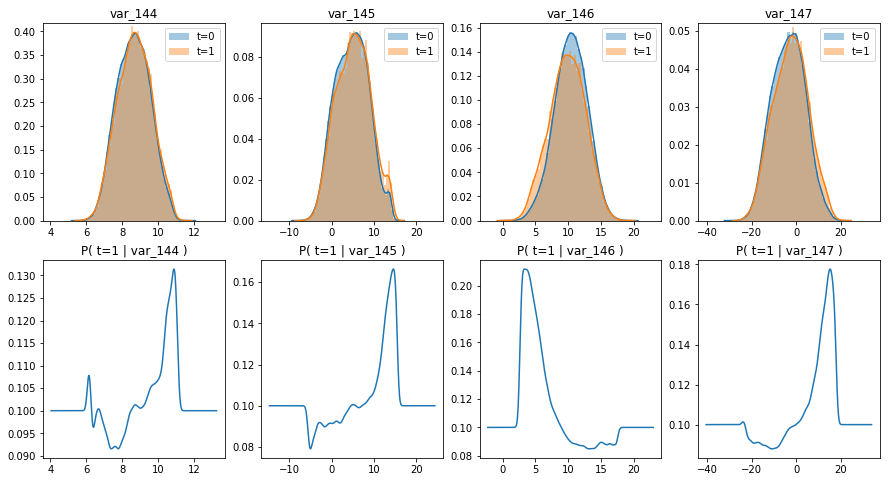

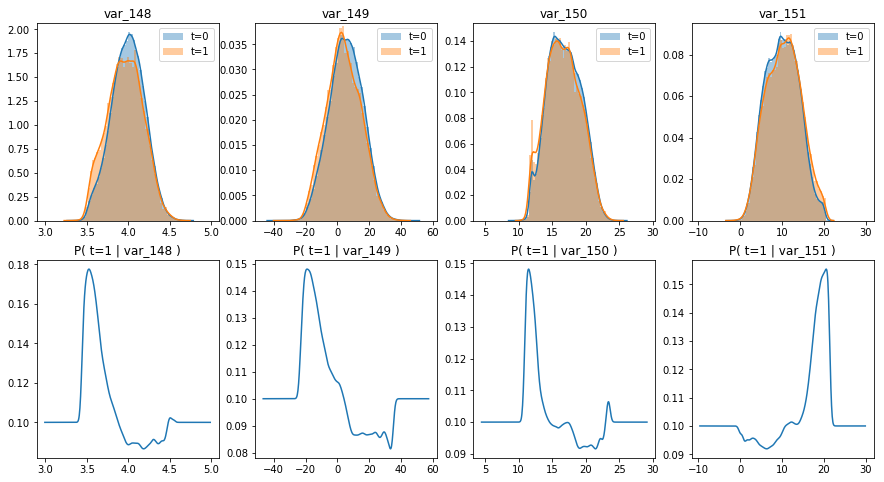

Showing vars 152 to 159 ...


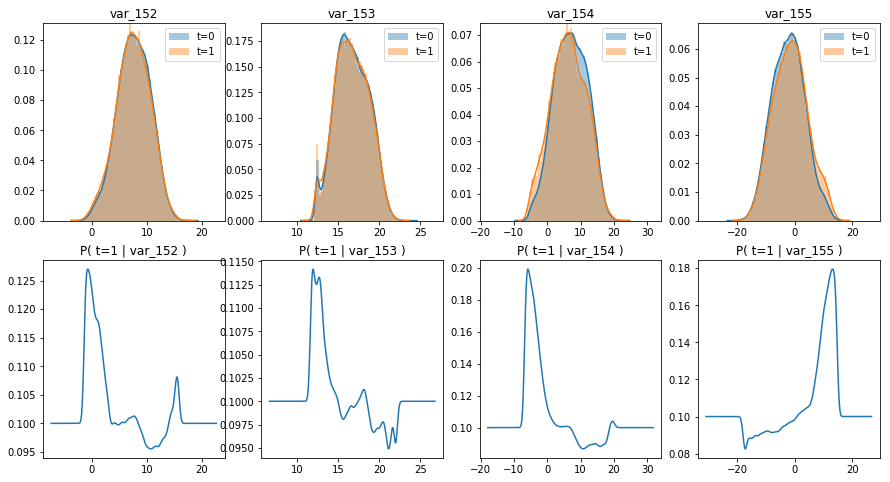

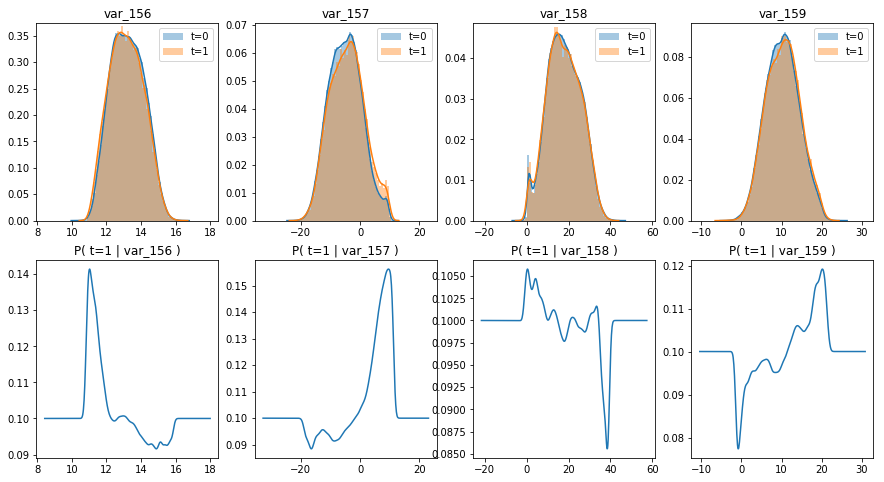

Showing vars 160 to 167 ...


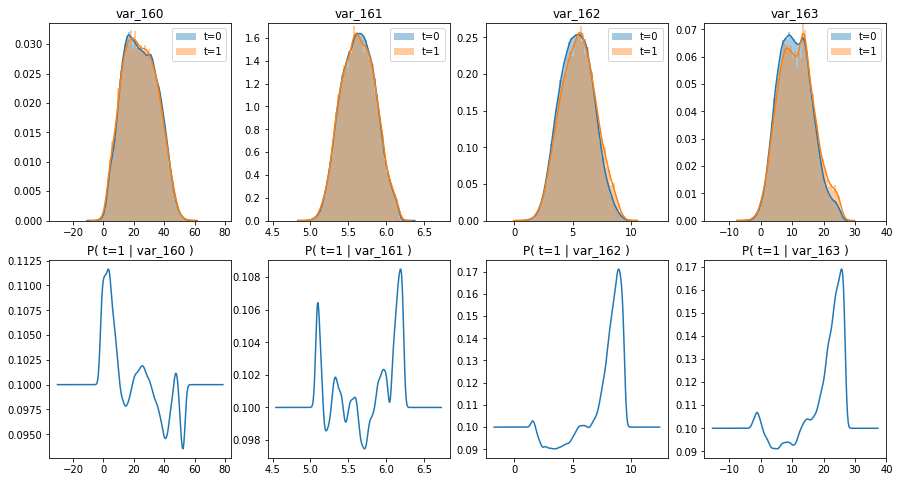

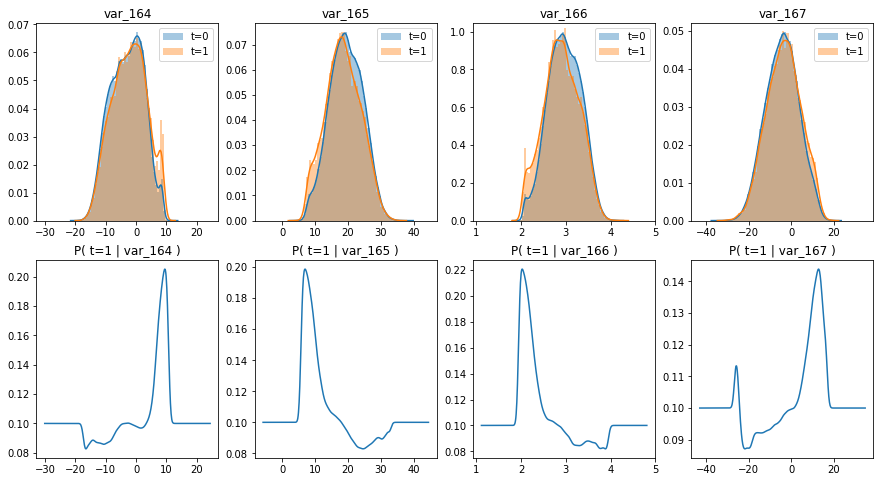

Showing vars 168 to 175 ...


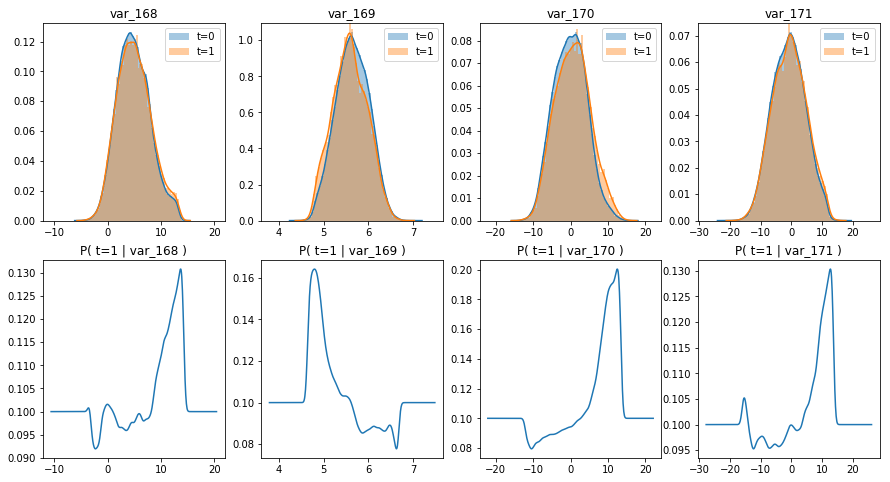

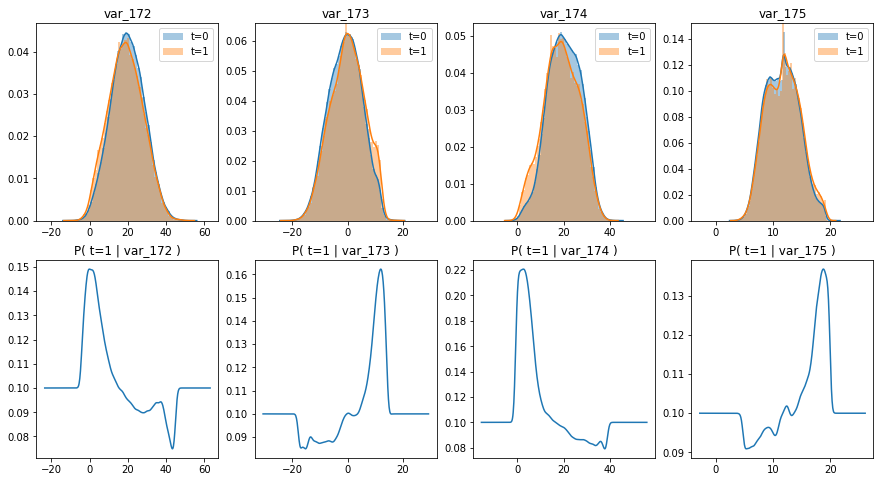

Showing vars 176 to 183 ...


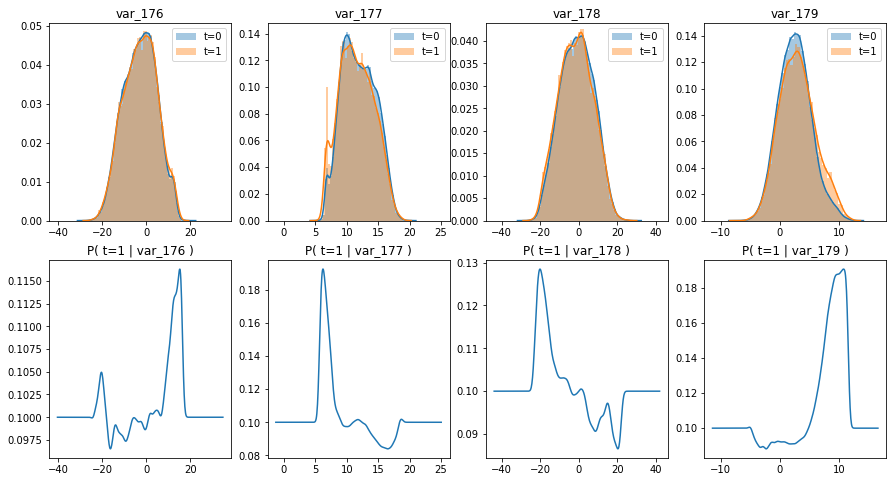

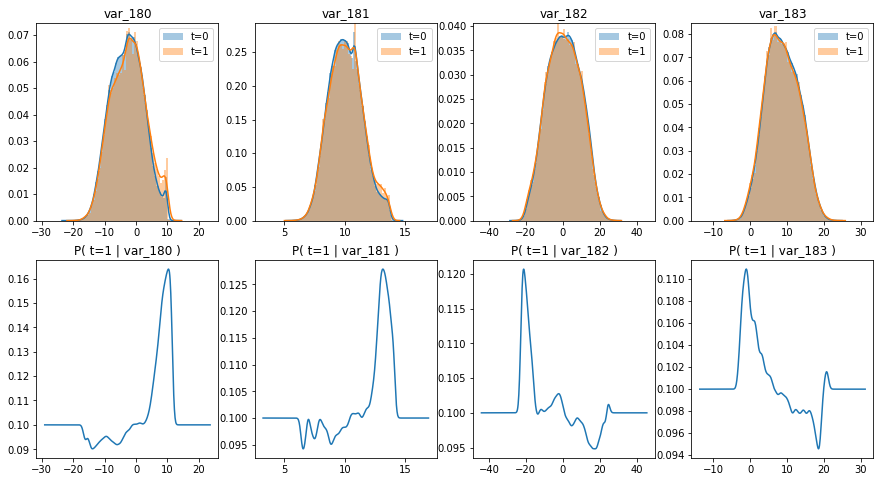

Showing vars 184 to 191 ...


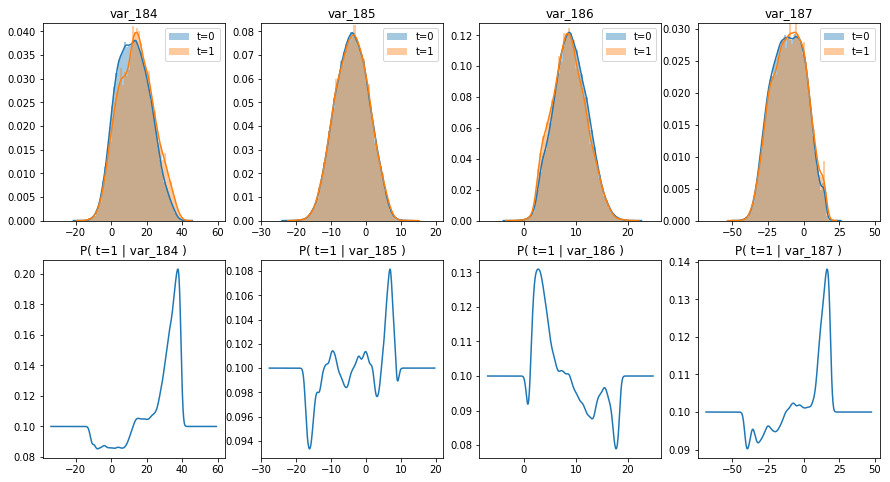

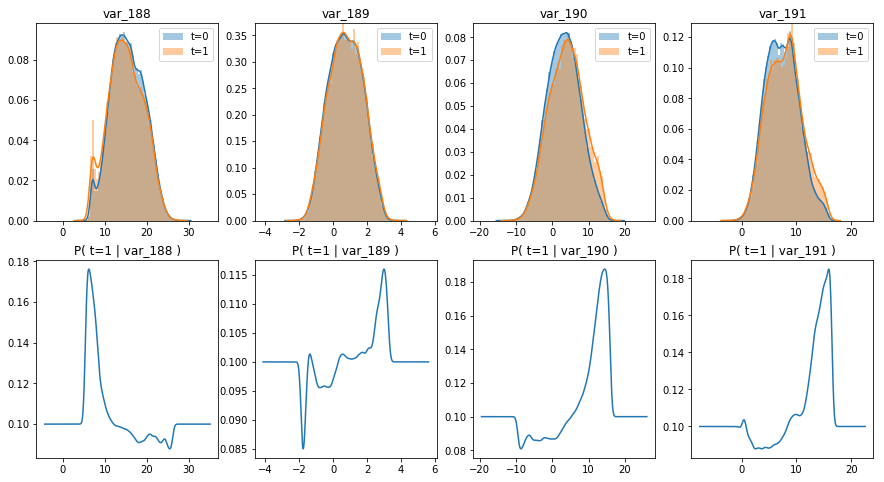

Showing vars 192 to 199 ...


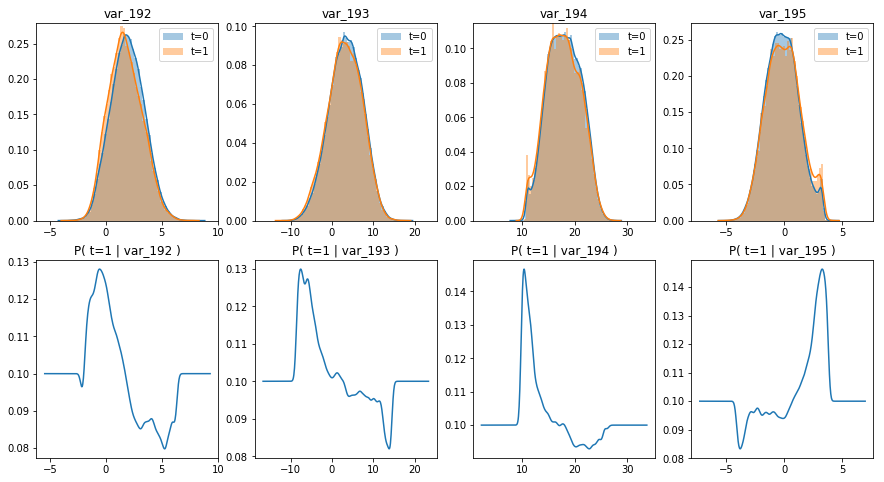

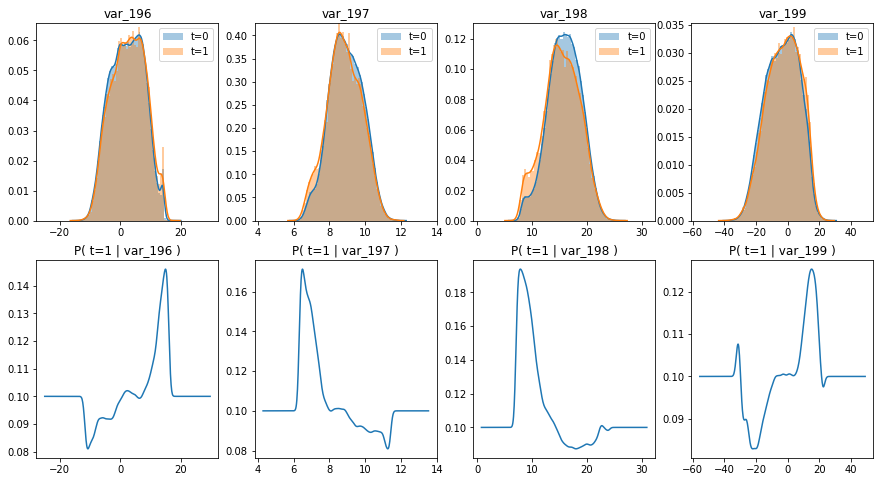

In [10]:
# DRAW PLOTS, YES OR NO
Picture = True
# DATA HAS Z-SCORE RANGE OF -4.5 TO 4.5
rmin=-5; rmax=5; 
# CALCULATE PROBABILITIES FOR 501 BINS
res=501
# STORE PROBABILITIES IN PR
pr = 0.1 * np.ones((200,res))
pr2 = pr.copy()
xr = np.zeros((200,res))
xr2 = xr.copy()
ct2 = 0
for j in range(50):
    if Picture: plt.figure(figsize=(15,8))
    for v in range(4):
        ct = 0
        # CALCULATE PROBABILITY FUNCTION FOR VAR
        for i in np.linspace(rmin,rmax,res):
            pr[v+4*j,ct] = getp(v+4*j,m[v+4*j]+i*s[v+4*j])
            xr[v+4*j,ct] = m[v+4*j]+i*s[v+4*j]
            xr2[v+4*j,ct] = i
            ct += 1
        if Picture:
            # SMOOTH FUNCTION FOR PRETTIER DISPLAY
            # BUT USE UNSMOOTHED FUNCTION FOR PREDICTION
            pr2[v+4*j,:] = smooth(pr[v+4*j,:],res//10)
            # DISPLAY PROBABILITY FUNCTION
            plt.subplot(2, 4, ct2%4+5)
            plt.plot(xr[v+4*j,:],pr2[v+4*j,:],'-')
            plt.title('P( t=1 | var_'+str(v+4*j)+' )')
            xx = plt.xlim()
            # DISPLAY TARGET DENSITIES
            plt.subplot(2, 4, ct2%4+1)            
            sns.distplot(train0['var_'+str(v+4*j)], label = 't=0')
            sns.distplot(train1['var_'+str(v+4*j)], label = 't=1')
            plt.title('var_'+str(v+4*j))
            plt.legend()
            plt.xlim(xx)
            plt.xlabel('')
        if (ct2%8==0): print('Showing vars',ct2,'to',ct2+7,'...')
        ct2 += 1
    if Picture: plt.show()


And looking at the picture of first decision. Notice that it finds the "bump" of var_81 and cuts it off. So if one was to create a feature that is based on artificially creating bins of var_81 or splitting var_81 into certain pre-defined ranges, this wouldn't be a fruitful excercise. This is because of the fact that tree based algorithms are able to create bins of the features automatically and need not be told explicitly about doing so.

It's second decision is to cut the "bump" off var_12. Then it chops var_139. These three decisions achieve validation AUC 0.6046. It predicts probability of target=1 to be 0.192, 0.182, 0.121, and 0.074 for it's four splits.